# Histograma puntos visitante
## Beatriz Cárdaba Rico
El objetivo es realizar un histograma con los puntos de los equipos visitantes a partir del archivo partidosLigaNBA.csv mediante Spark
Para ello se segurán los pasos pautados.


- IMPORTAMOS DATOS Y SPARK

 - Instalamos Apache y Spark

In [96]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

- Importamos JAVA_HOME y SPARK_HOME

In [97]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

 - Importamos findspark y SparkContext

In [98]:
import findspark
findspark.init()
from pyspark import SparkContext


 - Indicammos las caraterísticas del Sparkcontext

In [ ]:
.sc = SparkContext("local", "First App")

 - Importamos el cvs "partidosLigaNBA.csv"

In [101]:
data_file = "partidosLigaNBA.csv" # lo hemos subido a los archivos del colaborate
raw_data = sc.textFile(data_file) # lee los datos como texto según hemos indicado en sc

 - Visualizamos las primeras 5 filas

In [102]:
raw_data.take(5) # para ver las filas que indiquemos

['Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1',
 'Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74']

- Identificamos la primera fila y la eliminamos

In [103]:
header1 = raw_data.filter(lambda x: 'PTS' in x) #asiganmos el indice de las variables

In [104]:
datos = raw_data.subtract(header1) #substraemos el header

Ahora "datos" no tiene encabezado

In [108]:
datos.take(5)

['Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74',
 'Wed, Oct 31, 2007:"7:30 pm":Chicago Bulls:103:New Jersey Nets:112',
 'Wed, Oct 31, 2007:"7:00 pm":Milwaukee Bucks:83:Orlando Magic:102',
 'Thu, Nov 1, 2007:"8:00 pm":Detroit Pistons:91:Miami Heat:80',
 'Thu, Nov 1, 2007:"7:30 pm":Phoenix Suns:106:Seattle SuperSonics:99']

Separamos cada parte del string que componen las filas, en este caso están separadas las diferentes partes de cada fila con ":"

In [109]:
from pprint import pprint
data_separar = datos.map(lambda x: x.split(":")) #realizamos la separación de las variables

In [110]:
data_separar.take(5) #comprobamos

[['Wed, Oct 31, 2007',
  '"8',
  '00 pm"',
  'Dallas Mavericks',
  '92',
  'Cleveland Cavaliers',
  '74'],
 ['Wed, Oct 31, 2007',
  '"7',
  '30 pm"',
  'Chicago Bulls',
  '103',
  'New Jersey Nets',
  '112'],
 ['Wed, Oct 31, 2007',
  '"7',
  '00 pm"',
  'Milwaukee Bucks',
  '83',
  'Orlando Magic',
  '102'],
 ['Thu, Nov 1, 2007',
  '"8',
  '00 pm"',
  'Detroit Pistons',
  '91',
  'Miami Heat',
  '80'],
 ['Thu, Nov 1, 2007',
  '"7',
  '30 pm"',
  'Phoenix Suns',
  '106',
  'Seattle SuperSonics',
  '99']]

Creamos los datos de los puntos para los visitantes y los locales

In [111]:
#En la posición 4 están los puntos de local, #los puntos eran strings, al realizar el mapeo, los he convertido a númericos.
datos_puntos_local= data_separar.map(lambda x: int(x[6]))
datos_puntos_visit = data_separar.map(lambda x: int(x[4]))

In [112]:
datos_puntos_visit.take(10) # vemos que hemos creado una lista con los puntos del visitante

[92, 103, 83, 91, 106, 106, 83, 99, 96, 114]

- Definimos una función "intervalos" para asignar los puntos de los visitantes a un grupo en función de su valor. Definimos ocho posibles grupos:

In [113]:
def intervalos(x):   
  if x<50 : # si es menos de 50
	   return '1_int50' # asignamos el grupo 1 (ponemos el 1 delante para que lo ordene de manera ascendente)
  elif x<70:
	    return '2_int50_70'
  elif x<80:
      return '3_int70_80'
  elif x<90:
      return '4_int80_90'
  elif x<100:
      return '5_int90_100'
  elif x<110:
      return '6_int100_110'
  elif x<120:
      return '7_int110_120'
  elif x<200:
      return '8_int120_200'

Definimos la función que sea capaz de
* Extraer los datos. Del csv y separados por :

* Filtrar aquellos casos que no sean. Sólo queremos los dígitos

* Aplicar una función map que transforme cada número en uno de los intervalos del histograma (elegidos por vosotros mismos). Aplicar la función intervalos

* Método de agrupación para generar un vector formado por cada elemento asociado a cada intervalo.  ReduceByKEy

In [141]:
# FUNCION EXPLICADA
#puntos_intervalos = datos.map(lambda s: s.split(":")[-1]) \ #queremos que seleccione los datos separados por
                     # .filter(lambda puntos_visit: puntos_visit.isdigit()) \ # que seleccione los datos que son dígitos
                      #.map(lambda puntos_visit: int(puntos_visit)) \ # pasamos los puntos visitantes a formato int
                     # .map(lambda x : (intervalos(x),1)) \ # aplicamos la función intervalos a los puntos de visitantes
                      #.reduceByKey(lambda a, b: a + b) \ # queremos que agrupe por el intervalo asociado y sume todos los partidos de ese intervalo
                      #.collect()

In [136]:
puntos_intervalos = datos.map(lambda s: s.split(":")[-1]) \
                      .filter(lambda puntos_visit: puntos_visit.isdigit()) \
                      .map(lambda puntos_visit: int(puntos_visit)) \
                      .map(lambda x : (intervalos(x),1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .collect()

In [137]:
puntos_intervalos # vemos los puntos agrupados según el intervalo


[('7_int110_120', 2276),
 ('6_int100_110', 3976),
 ('2_int50_70', 37),
 ('3_int70_80', 365),
 ('4_int80_90', 1615),
 ('5_int90_100', 3611),
 ('8_int120_200', 1017)]

 - Ordenamos los datos en función del primer dígito del nombre del grupo

In [139]:

puntos_intervalos.sort()

- Importamos pandas y numpy para poder crear un dataframe de los datos obtenidos

In [ ]:
import pandas as pd
import numpy as np
puntos_intervalos_df = pd.DataFrame(puntos_intervalos)

- Importamos Matplot para dibujar el histograma

In [ ]:

import matplotlib.pyplot as plt

- Dibujamos el Histograma:

([<matplotlib.axis.YTick at 0x7f40df4d6f28>,
 <a list of 7 Text major ticklabel objects>)

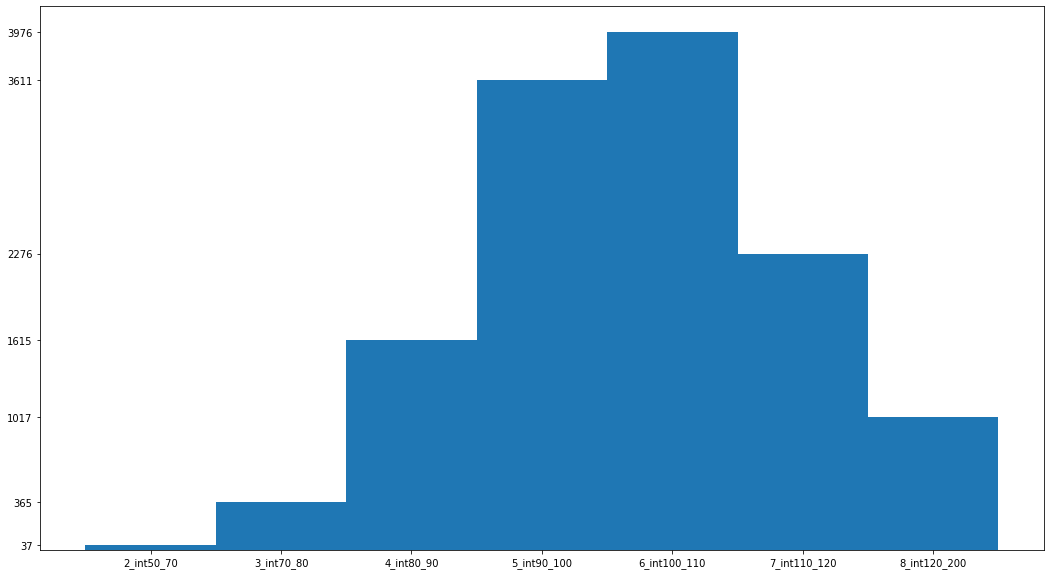

In [140]:

intervalos_names, y_points = zip(*puntos_intervalos) # separamos en los nombres de los intervalos y los puntos asociados
intervalos_num = np.arange(len(intervalos_names)) # número de categorias creadas


f, ax = plt.subplots(figsize=(18,10)) # establecemos el tamaño del histograma
plt.bar(intervalos_num, y_points, width = 1, align='center') # queremos que dibuje los intervalos y los puntos

plt.xticks(intervalos_num, intervalos_names)  # Establece las ubicaciones y las etiquetas. Que a los 8 intervalos les ponga su nombre que se ha separado en intervalos_names
plt.yticks(y_points) # Establece las ubicaciones y las etiquetas. Los puntos